https://pytorch-forecasting.readthedocs.io/en/v1.2.0/tutorials/nhits.html

https://pytorch-forecasting.readthedocs.io/en/v1.2.0/api/pytorch_forecasting.metrics.distributions.MQF2DistributionLoss.html#pytorch_forecasting.metrics.distributions.MQF2DistributionLoss

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import lightning.pytorch as ptl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd

from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MQF2DistributionLoss

In [3]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,-0.046501,2,2020-01-02
2,0,2,-0.097796,2,2020-01-03
3,0,3,-0.144397,2,2020-01-04
4,0,4,-0.177954,2,2020-01-05


In [4]:
data.tail()

,series,time_idx,value,static,date
39995,99,395,-5.587069,2,2021-01-30
39996,99,396,-4.986342,2,2021-01-31
39997,99,397,-5.630228,2,2021-02-01
39998,99,398,-5.745145,2,2021-02-02
39999,99,399,-4.690036,2,2021-02-03


In [5]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-HiTS can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(
    training, data, min_prediction_idx=training_cutoff + 1
)
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0
)

In [6]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(
    val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True
)
SMAPE()(baseline_predictions.output, baseline_predictions.y)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores


tensor(0.5462)

In [7]:
ptl.seed_everything(42)
trainer = ptl.Trainer(accelerator="cpu", gradient_clip_val=0.1)
net = NHiTS.from_dataset(
    training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    loss=MQF2DistributionLoss(prediction_length=prediction_length),
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
)

Seed set to 42
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores


In [8]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e-1,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

`weights_only` was not set, defaulting to `False`.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /home/volody/code/study-py/ts-pytorch/Chapter_6/.lr_find_4cfe027d-a0a6-47f5-8548-f13dee1a1ed3.ckpt


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL pytorch_forecasting.data.encoders.EncoderNormalizer was not an allowed global by default. Please use `torch.serialization.add_safe_globals([pytorch_forecasting.data.encoders.EncoderNormalizer])` or the `torch.serialization.safe_globals([pytorch_forecasting.data.encoders.EncoderNormalizer])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [9]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
trainer = ptl.Trainer(
    max_epochs=5,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=1.0,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    enable_checkpointing=True,
)


net = NHiTS.from_dataset(
    training,
    learning_rate=5e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores

  | Name            | Type                 | Params | Mode  | FLOPs
-------------------------------------------------------------------------
0 | loss            | MQF2DistributionLoss | 5.1 K  | train | 0    
1 | logging_metrics | ModuleList           | 0      | train | 0    
2 | embeddings      | MultiEmbedding       | 0      | train | 0    
3 | model           | NHiTS                | 35.7 K | train | 0    
-------------------------------------------------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [11]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NHiTS.load_from_checkpoint(best_model_path, weights_only=False)

In [12]:
predictions = best_model.predict(
    val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True
)
MAE()(predictions.output, predictions.y)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores


tensor(0.1827)

In [13]:
raw_predictions = best_model.predict(
    val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu")
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores


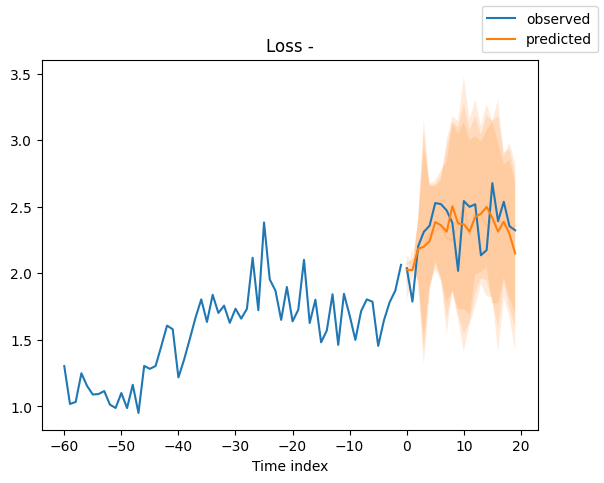

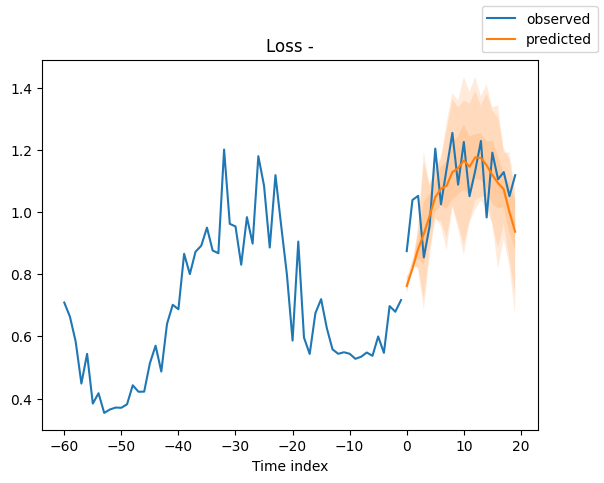

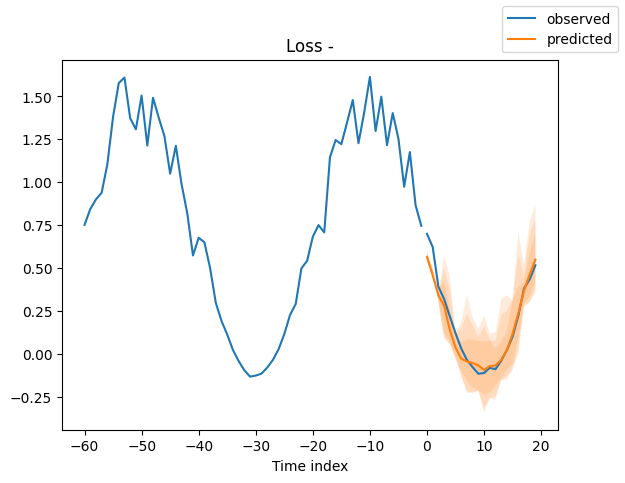

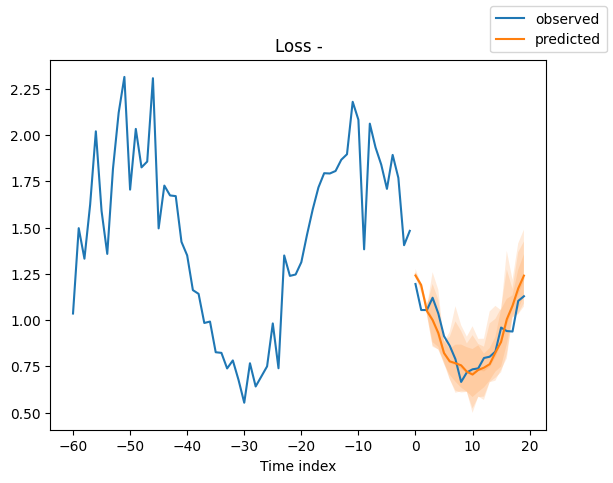

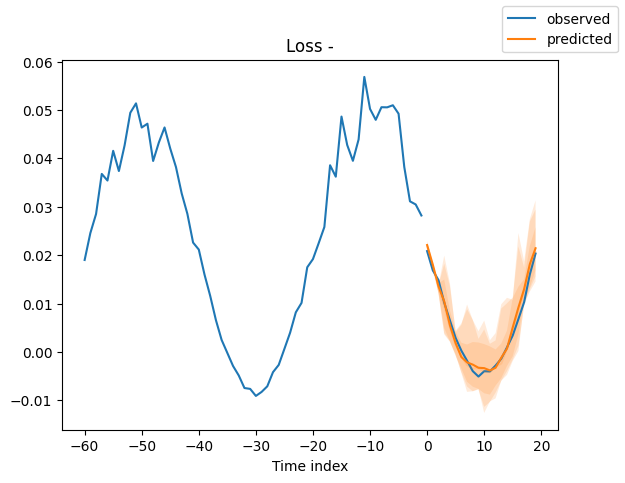

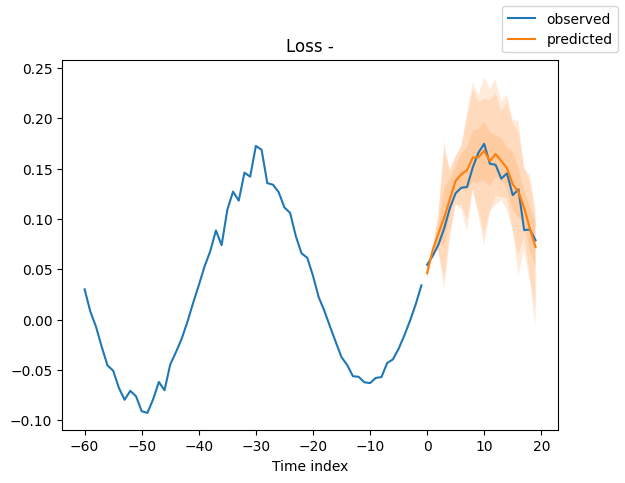

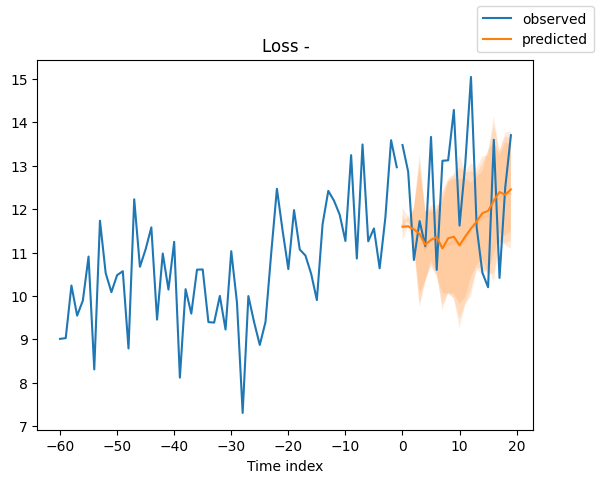

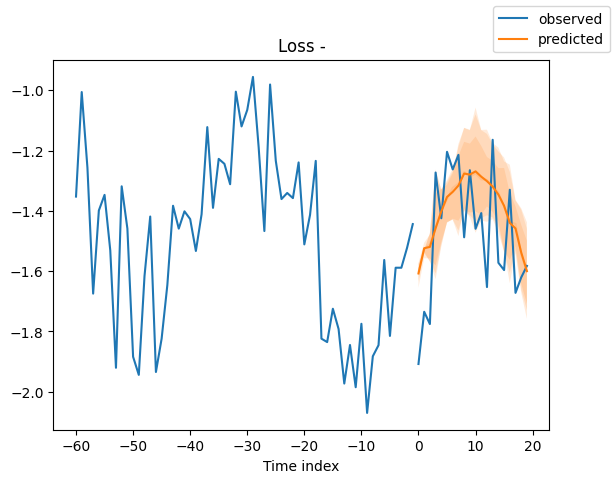

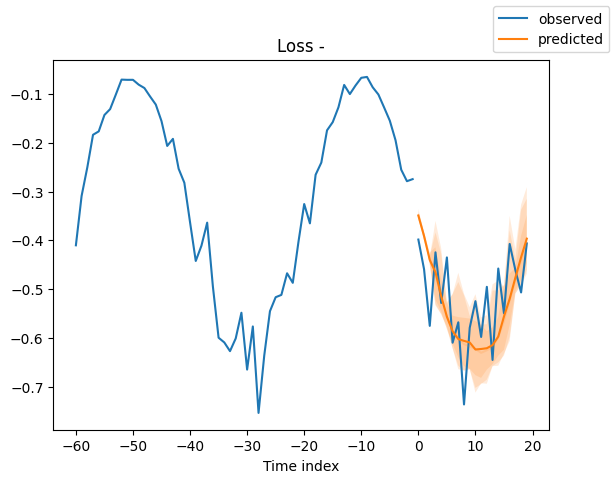

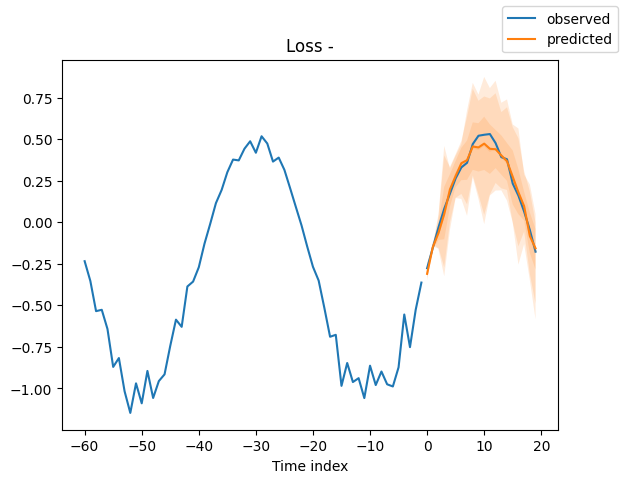

In [14]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(
        raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True
    )

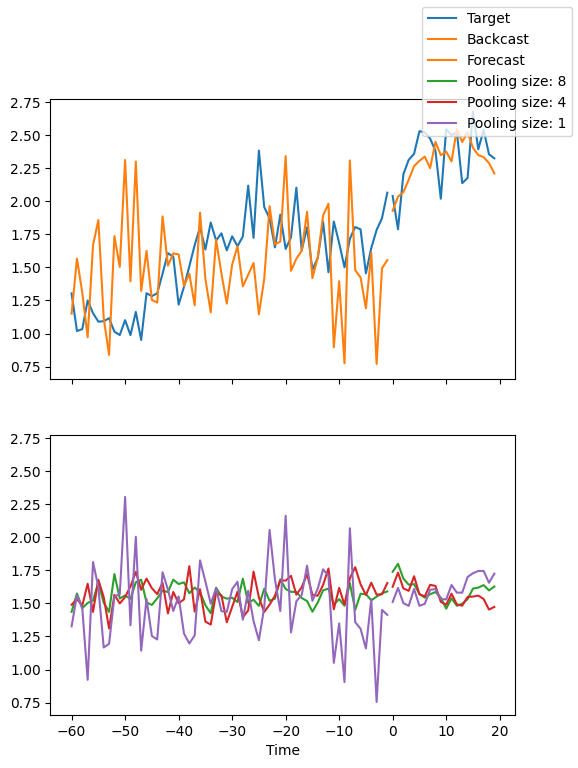

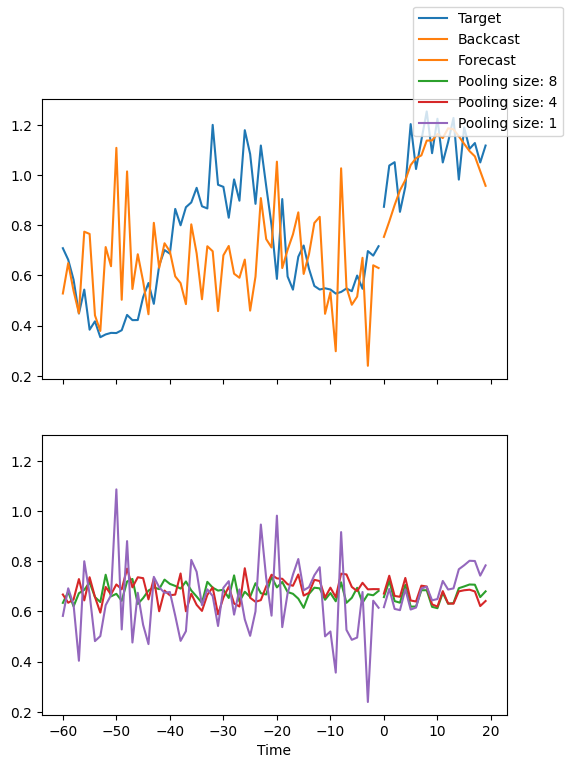

In [15]:
for idx in range(2):  # plot 10 examples
    best_model.plot_interpretation(raw_predictions.x, raw_predictions.output, idx=idx)

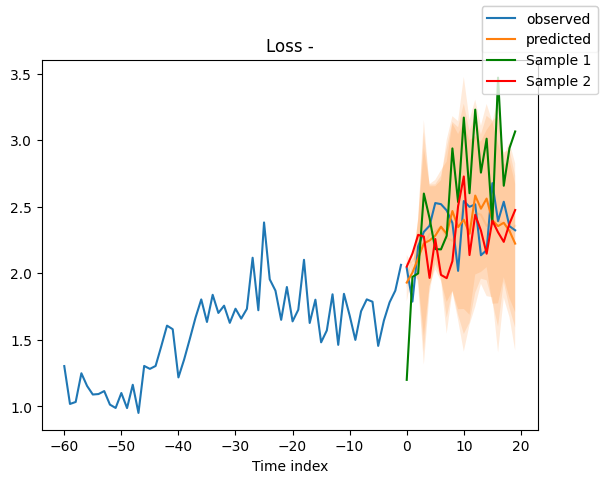

In [16]:
# sample 500 paths
samples = best_model.loss.sample(
    raw_predictions.output["prediction"][[0]], n_samples=500
)[0]

# plot prediction
fig = best_model.plot_prediction(
    raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True
)
ax = fig.get_axes()[0]
# plot first two sampled paths
ax.plot(samples[:, 0], color="g", label="Sample 1")
ax.plot(samples[:, 1], color="r", label="Sample 2")
fig.legend()

In [17]:
print(f"Var(all samples) = {samples.var():.4f}")
print(f"Mean(Var(sample)) = {samples.var(0).mean():.4f}")

Var(all samples) = 0.1712
Mean(Var(sample)) = 0.1431


Text(0, 0.5, 'Frequency')

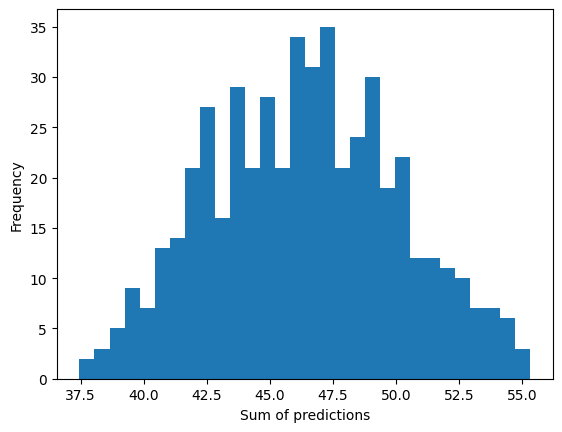

In [18]:
plt.hist(samples.sum(0).numpy(), bins=30)
plt.xlabel("Sum of predictions")
plt.ylabel("Frequency")